# E01 Data

Using examples: https://github.com/mtpatter/eo1-demo

See data in: \\OLYMPUS\Projects\1010115-PIPELINE-II\Technical Work\Data\E01

Copy `E01...` directories into this directory and set variable `data` below to the directory of choice

In [1]:
data = 'EO1A0120292016222110P0'

# data = [
#     'EO1A0120292016222110P0',
#     'EO1A0120292016331110P0',
#     'EO1A0120292016173110P0',
#     'EO1A0120292016075110P0'
# ]

## E01 Data

In [2]:
import os
import podpac as pc
import traitlets as tl
import rasterio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# make absolute paths
data = os.path.abspath(data)

### E01 Podpac Node

In [4]:
import e01classify
import time
import podpac

class E01Source(pc.data.Rasterio):
    # parameters
    source = tl.Unicode()  # full path to the directory of the E01 images
    spectral_band = tl.Int(default_value=3)
    product = tl.Unicode(default_value='L1GST')
    
    # attributes
    entity_id = tl.Unicode()
    dataset = tl.Any()
    interpolation = pc.data.interpolation_trait(default_value={
        'method': 'nearest',
        'interpolators': [pc.interpolators.Rasterio, pc.interpolators.ScipyGrid, pc.interpolators.ScipyPoint]
    })

    @tl.default('entity_id')
    def _get_entity_id(self):
        return os.path.split(self.source)[-1]
    
    @tl.default('dataset')
    def _open_dataset(self):
        """Opens the data source"""
        
        filename = os.path.join(self.source, '{}_B{}_{}.TIF'.format(self.entity_id, str(self.spectral_band).zfill(2), self.product))
        return rasterio.open(filename)
    
    def classify(self, classes='FourClassTrainingSet.txt'):
        """classify E01 using model (all bands)
        developed in https://github.com/mtpatter/eo1-demo
        """
        
        filePre = os.path.join(self.source, self.entity_id)
        output = os.path.join(self.source, 'classification.tif')
        
        # set up classification class
        self._classify = e01classify.test(filePre, output)
        
        # import classify module
        startTime = time.time()
        self._classify.setUpTest()
        self._classify.setUpTrain(classes)

        self._classify.addBand(np.arange(9))
        self._classify.addRatio((3,7))
        self._classify.addRatio((4,8))

        print("About to begin Test")
        self._classify.svmTrain()
        self._classify.svmTest()

        
        print("Writing output")
        self._classify.writeTif(output)
        return podpac.data.Rasterio(output)
    
        self._classify.elapsed = time.time()-startTime
        print("Time Elapsed: ", self._classify.elapsed)

In [5]:
node = E01Source(source=data)
raw = node.eval(node.native_coordinates)

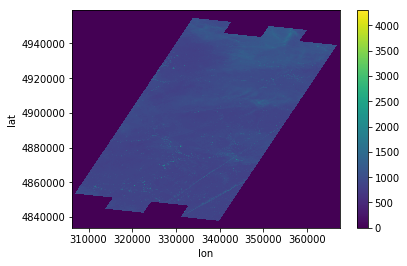

In [7]:
raw.plot.imshow(interpolation="none")

In [16]:
node = pc.data.Rasterio(source='test.tif')
o = node.eval(node.native_coordinates)

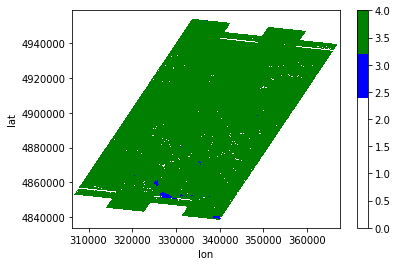

In [21]:
cmap = plt.cm.get_cmap('PiYG',5)
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (0,0,0,0) #Border pixels
cmaplist[1] = (1.0,1.0,1.0,1.0) #Cloud
cmaplist[2] = (.5,.5,0,0) #Desert
cmaplist[3] = (0,0,1.0,1.0) #Water
cmaplist[4] = (0,.5,0,1.0) #Vegetation
cmap = cmap.from_list('Custom cmap',cmaplist,cmap.N)

o.plot.imshow(interpolation="none",cmap = cmap)

## Classify Example

In [5]:
import classify
import time
import os

filePre = os.path.join(node.source, node.entity_id)
output = os.path.join(node.source, 'classification.tif')
f = classify.test(filePre, output)

In [6]:
# import classify module
startTime = time.time()
f.setUpTest()
f.setUpTrain('FourClassTrainingSet.txt')

f.addBand(np.arange(9))
f.addRatio((3,7))
f.addRatio((4,8))

print("About to begin Test")
f.svmTrain()
f.svmTest()

f.writeTif(savepath)
print("Time Elapsed: ", time.time()-startTime)